The naming of variables, columns etc. is according to the in the paper.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import missingno as msno
import seaborn as sns
import joblib
import os
from tqdm import tqdm
from sklearn.metrics import r2_score
from sklearn.linear_model import Ridge

In [2]:
# see footnote [22]
columns = ["b/m", "de", "dfr", "dfy", "dp", "dy", "ep", "infl", "ltr", "lty", "ntis", "svar", "tbl", "tms", "lag_returns"]

nber = pd.read_csv("data/NBER_20210719_cycle_dates_pasted.csv")[1:]
nber["peak"] = pd.to_datetime(nber["peak"])
nber["trough"] = pd.to_datetime(nber["trough"])

data_raw = pd.read_csv("data/PredictorData2021 - Monthly.csv")
data_raw["yyyymm"] = pd.to_datetime(data_raw["yyyymm"], format='%Y%m', errors='coerce')
data_raw["Index"] = data_raw["Index"].str.replace(",", "")
data_raw = data_raw.set_index("yyyymm")
data_raw[data_raw.columns] = data_raw[data_raw.columns].astype(float)
data_raw = data_raw.rename({"Index":"prices"}, axis=1)

# Calculate missing columns according to the explaination in m Welch and Goyal (2008) 
data_raw["dfy"] = data_raw["BAA"] - data_raw["AAA"]
data_raw["tms"] = data_raw["lty"] - data_raw["tbl"]
data_raw["de"] = np.log(data_raw["D12"]) - np.log(data_raw["E12"])
data_raw["dfr"] = data_raw["corpr"] - data_raw["ltr"]
data_raw["lag_price"] = data_raw["prices"].shift()
data_raw["dp"] = np.log(data_raw["D12"]) - np.log(data_raw["prices"])
data_raw["dy"] = np.log(data_raw["D12"]) - np.log(data_raw["lag_price"])
data_raw["ep"] = np.log(data_raw["E12"])  - np.log(data_raw["prices"])

data_raw["returns"] = data_raw["prices"].pct_change()
data_raw["lag_returns"] = data_raw["returns"].shift()

returns = data_raw["returns"].copy()
prices = data_raw["prices"].copy()

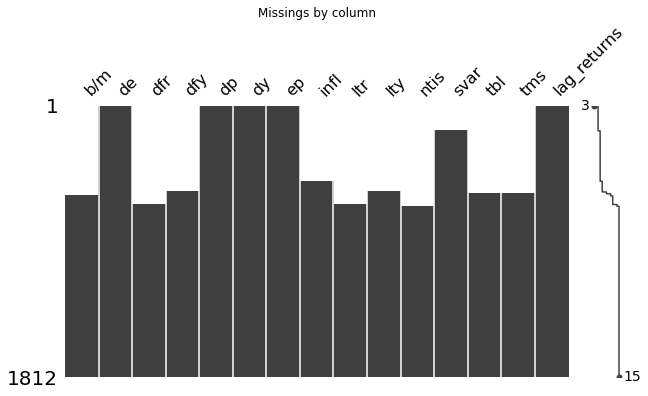

In [3]:
msno.matrix(data_raw[columns], figsize=(10,5))
plt.title("Missings by column")
plt.savefig("plots/missing_pattern.jpg")
plt.show()
data = data_raw[columns].dropna()
returns = returns[returns.index.isin(data.index)]

# Standarize data

> We volatility standardize returns and predictors using backward-looking standard deviations that preserve the out-of-sample nature of our forecasts. 

> Returns are standardized by their trailing 12-month return standard deviation (to capture their comparatively fastmoving conditional volatility), while predictors are standardized using an expanding window historical standard deviation (given the much higher persistence of most predictors). 

> We require 36 months of data to ensure that we have enough stability in our initial predictor standardization, so the final sample that we bring to our analysis begins in 1930. We perform this standardization to align the empirical analysis with our homoskedastic theoretical setting, **but our results are insensitive to this step (none of our findings are sensitive to variations in how standardizations are implemented)**

I did try a few different normalizations and the end results seems to be nearly the same.

In [4]:
for col in columns:
    data[col] = (data[col] - data[col].expanding(36).mean())/data[col].expanding(36).std()
# Standarize return by the std of the last 12 values
returns_std = returns.rolling(12).std().shift()
returns = returns / returns_std

data = data[36:]
returns = returns[36:]

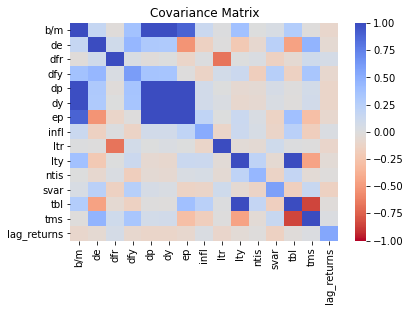

In [5]:
sns.heatmap(data[columns].cov(), center=0, vmin=-1, vmax=1, cmap=sns.color_palette("coolwarm_r", as_cmap=True))
fig = plt.gcf()
fig.figsize = (10,10)
plt.title("Covariance Matrix")
plt.savefig("plots/covariance.jpg")
plt.show()

# Random Fourier Features

In [6]:
data = data[columns].copy()

if "data.parquet" not in os.listdir("data"):
    print("Calculating omegas.")
    omegas = []
    for i in tqdm(range(6000)): # 6000*2 == 12000 == P
        omega = np.random.normal(0, 2, len(columns))
        data[f"sin_{i}"] = np.sin(data[columns] @ omega)
        data[f"cos_{i}"] = np.cos(data[columns] @ omega)
        omegas.append(omega)
    joblib.dump(omegas, "data/omegas.joblib")
    data.to_parquet("data/data.parquet")

else:
    omegas = joblib.load("data/omegas.joblib")
    data = pd.read_parquet("data/data.parquet")
    print("data & omegas.joblib loaded.")

print("Shape of data after generating RFFs:", data.shape)

data & omegas.joblib loaded.
Shape of data after generating RFFs: (1105, 12015)


# Model

Ridge Regression with Moore-Penrose pseudo-inverse:

This is the formula from the paper, *run time of 6mins*

> ```beta = np.linalg.pinv(z*np.identity(nr_cols) +  (S.T @ S)/T) @ (R @ S)/T```

Normal Inverse (not numerically stable if not full rank), *run time of 25sec*

>```beta = np.linalg.inv(z*np.identity(nr_cols) +  (S.T @ S)/T) @ (R @ S)/T```

Note: I did not observe different results with inv() vs. pinv(). 


This formula (notice that the division by `T` is missing) is equivalent to the sklearn ridge regression but orders of magnitude slower (*numpy: 6mins, Sklearn: 45ms*)
>```beta = np.linalg.pinv(z*np.identity(nr_cols) +  (S.T @ S)) @ (R @ S)```


Since the Sklearn solution is 8.000 times faster, I will proceed with that solution. `np.linalg.pinv()`.

I did only test ~100 iterations in the comparision between `pinv()`, `inv()` and `Ridge()` to the runtime of 6min per calculation of pinv()


In [7]:
%%time
z_values = [10**-3, 10**2, 10**3,  10**4,  10**5, 10**6, 10**7, 10**8, 10**9]
t_values = list(range(12, data.shape[0]))
if "backtest.parquet" not in os.listdir("data"):
    backtest = []
    for t in tqdm(t_values[:-1]):
        for z in z_values:
            regression_data = data.drop(columns, axis=1)

            R = returns[t-12+1:t+1].values      # y_train
            R_s = returns[t+1:t+2].values       # y_test
            R_s_index = returns[t+1:t+2].index  # y_test
            S = regression_data[t-12:t]         # X_train
            S_t = regression_data[t:t+1]        # X_test
            T, nr_cols = S.shape

            beta = Ridge(alpha=z, solver="svd", fit_intercept=False, normalize=False).fit(S, R).coef_
            beta_norm = np.sqrt((beta**2).sum())

            forecast = S_t @ beta
            timing_strategy = forecast * R_s # pi

            backtest.append({"z":z, "t":t, "beta_norm":beta_norm, 
                "index":forecast.index[0], "forecast":forecast.values[0], 
                "timing_strategy_index":R_s_index[0], "timing_strategy":timing_strategy.values[0], "return":R_s[0]
            })
    backtest = pd.DataFrame(backtest).set_index("index")

    backtest["return_denorm"] = (backtest["return"]*returns_std).dropna()
    backtest["forecast_denorm"] = (backtest["forecast"]*returns_std).dropna()

    backtest.to_parquet("data/backtest.parquet")
else:
    backtest = pd.read_parquet("data/backtest.parquet")
    print("backtest.parquet loaded.")

100%|██████████| 1092/1092 [12:32<00:00,  1.45it/s]

Wall time: 12min 32s


# Result

Note: **Footnote [25]**
> More specifically, the first column reports summary statistics for the market return with rolling 12-month volatility standardization. Thus, the buy-and-hold version of this asset is itself a basic timing strategy, where timing is inversely proportional to rolling volatility. We do this simply because the standardized market is the target in our forecasting analysis. Our results across the board are generally insensitive to, and our conclusions entirely unaffected by, whether we work with the raw or volatility standardized market return. As noted earlier, we prefer to use the volatility standardized market because it aligns more directly with our theoretical framework.

**Expected result:**

|    | High Complexity Machine |
|----|-------------------------|
|  z |                    1000 |
|  c |                    1000 |
| R2 |                      8% |
| SR | 0.46                    |
| IR | 0.31                    |

Page 48 reports R2 as "per month". The Sharpe Ratio value seems to be more fitting if you annualize the data.

Overall, I am confused by the result. The resulting plot at the end looks nearly identical to the paper which is a good hint that the overall calculation is correct.

R2 gets bigger for higher z and IR is not only never positive, but it also gets lower for higher z. I think that I am missing something about how the forecast is being compared with the actual returns since R2 and IR seem off. 

It seems like I do not (yet) understand page 40:
> This is of course not the case for the US market return, and therefore to adjust for buy-andhold market exposure we calculate the out-of-sample alpha, alpha t-statistic, and information ratio (IR) of the timing strategy return via time series regression on the un-timed market.

In [12]:
result = []
for z in z_values:
        df = backtest[backtest["z"] == z]
        time_factor = 12 # 12 to get annual values
        mean = df["timing_strategy"].mean()*time_factor
        std = df["timing_strategy"].std()*np.sqrt(time_factor)
        mean_return = df["return"].mean()*time_factor
        result.append({
            "log10(z)" : np.log10(z),
            "beta_norm_mean" : df["beta_norm"].mean(),
            "SR_market" : (df["return"].mean()*time_factor)/(df["return"].std()*np.sqrt(time_factor)),

            "timing_strategy_mean" : mean,
            "timing_strategy_var" : std,
            "R2" : r2_score(df["timing_strategy"], df["return"]),
            "SR" : mean/std,
            "IR" : (mean - mean_return)/std,
            "Alpha" : mean - mean_return, 
        })
result = pd.DataFrame(result)
result.round(4)

,log10(z),beta_norm_mean,SR_market,timing_strategy_mean,timing_strategy_var,R2,SR,IR,Alpha
0,-3.0,0.0526,0.5237,0.1925,1.1038,-1.143370e+01,0.1744,-1.7075,-1.8848
1,2.0,0.0514,0.5237,0.1846,1.0723,-1.218390e+01,0.1722,-1.7651,-1.8927
2,3.0,0.0436,0.5237,0.1656,0.9036,-1.750000e+01,0.1833,-2.1158,-1.9117
3,4.0,0.0186,0.5237,0.0984,0.4171,-8.678760e+01,0.2358,-4.7448,-1.9790
4,5.0,0.0029,0.5237,0.0205,0.0772,-2.668795e+03,0.2658,-26.6600,-2.0569
5,6.0,0.0003,0.5237,0.0023,0.0087,-2.121458e+05,0.2670,-238.4162,-2.0751
6,7.0,0.0000,0.5237,0.0002,0.0009,-2.066327e+07,0.2669,-2353.7797,-2.0771
7,8.0,0.0000,0.5237,0.0000,0.0001,-2.060807e+09,0.2669,-23507.1488,-2.0774
8,9.0,0.0000,0.5237,0.0000,0.0000,-2.060255e+11,0.2669,-235040.8127,-2.0774


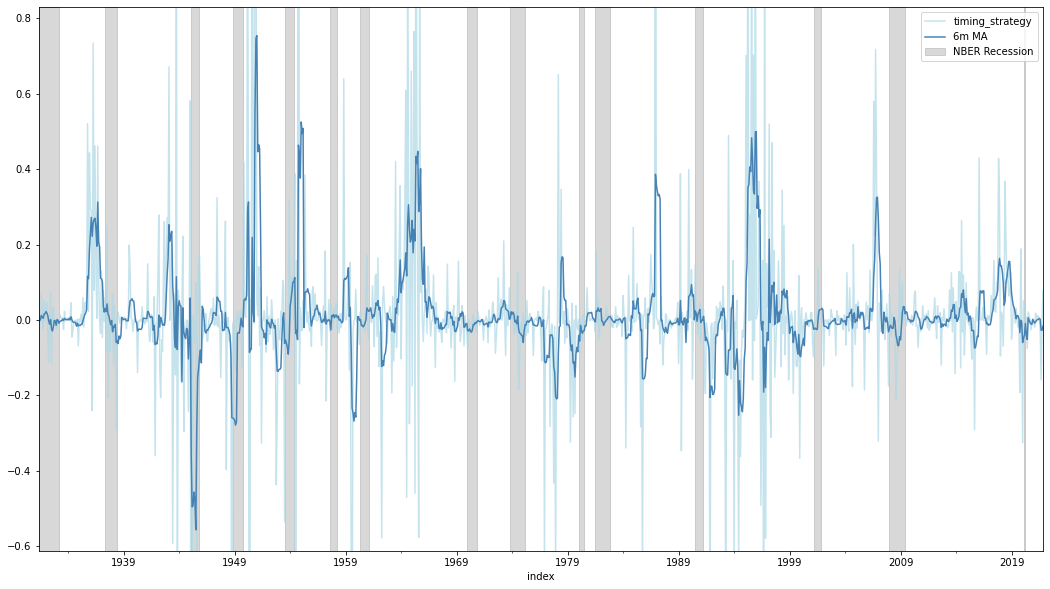

In [13]:
plot_data = pd.DataFrame()
plot_data["timing_strategy"] = backtest.loc[backtest["z"] == 1000, "timing_strategy"]
plot_data["6m MA"] = plot_data["timing_strategy"].rolling(6).mean()

recessions = [t for date_list in nber.apply(lambda x: pd.date_range(x["peak"], x["trough"]), axis=1).values for t in date_list]
plot_data["NBER Recession"] = plot_data.index.isin(recessions).astype(int)

plot_data = plot_data.dropna()

fig, ax = plt.subplots(figsize=(18,10))
plot_data["timing_strategy"].plot(ax=ax, alpha=0.7, c="lightblue")
plot_data["6m MA"].plot(ax=ax, c="steelblue")
ax.set_ylim(plot_data["6m MA"].min()*1.1, plot_data["6m MA"].max()*1.1)
ax.fill_between(plot_data.index, ax.get_ylim()[0], ax.get_ylim()[1], 
                where=plot_data["NBER Recession"] == 1 ,color='grey', alpha=0.3,  label="NBER Recession")
ax.legend(loc="upper right")
plt.savefig("plots/result.jpg")
plt.show()

## Expected plot:
![Expected plot](plots/expected_result.png "Expected plot")